# Final exam (take-home; <u>due 5/12</u>)

You will need the same packages you've used for the homework assignments.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#from sklearn.exceptions import ConvergenceWarning 
warnings.filterwarnings(action='ignore')

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from keras.models import Sequential
import keras
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras import regularizers

from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cmx
from keras.models import Model

from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

import networkx as nx
from sklearn.neighbors import NearestNeighbors


Using TensorFlow backend.


## Part 1: Handwritten digits (small)

First, load the dataset (which, in the interest of time, is rather small) and perform a test-train split; please retain the random seed value (so results are repeatable across different runs of the code).

In [2]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

digits = load_digits()

X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.25, random_state=0)

Let's also examine a few of the actual images, to get an idea of what the data looks like:

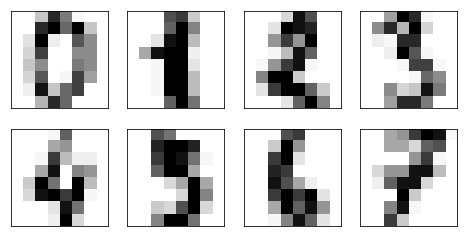

In [3]:
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(digits.images[i], cmap=plt.cm.Greys)

In [4]:
def show_images(images, cols = 5, cmap=plt.cm.gray, im_shape=None, fig=None):
    """Display a set of images.
    
    images: Either a (N,K) or (N,K,L) array. If 2D, then each row will be reshaped to a rectangle.
    im_shape: If images is 2D, the shape of each image. If omitted, defaults to (sqrt(K),sqrt(K)).
    cols: Number of columns in subplots; rows is ceil(N/cols).
    cmap: Colormap to use."""
    if fig is None:
        fig = plt.figure()
    dims = images.shape
    if len(dims) not in (2,3):
        raise ValueError("images must be either 2D or 3D array")
    if len(dims) == 3:
        if im_shape is not None:
            raise ValueError("im_shape redundant when images is a 3D array")
        else:
            im_shape = dims[1:]
    if len(dims) == 2 and im_shape is None:
        L = int(np.sqrt(dims[1]))
        if L*L != dims[1]:
            raise ValueError("im_shape is missing and number of columns not a perfect square")
        im_shape = (L, L)
    N = dims[0]
    rows = (N + cols - 1)//cols
    for i in range(N):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(images[i,...].reshape(im_shape), cmap=cmap)
        

### 1.1 Baseline classification

To establish a baseline, train a logistic regression model.  Explain how you chose any hyper-parameters, and evaluate it on the test set.

First, train a logitic regression with default L2 regularizer and 'lbfgs' solver:

In [6]:
# TODO - Your code here

# Normalized features to accelerate convergence
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
scaler = preprocessing.StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)     
x_test_scaled = scaler.fit_transform(X_test) 

lr1 = LogisticRegression(solver='lbfgs', multi_class='multinomial')
lr1.fit(x_train_scaled, y_train)
print("Train score: %f" % lr1.score(x_train_scaled, y_train))# train accuracy: 99.85%
print("Test score: %f" % lr1.score(x_test_scaled, y_test))# test accuracy: 97.33%

Train score: 0.998515
Test score: 0.973333


Try different solvers and compare the performance. The 'lbfgs' and the 'newton-cg' gave the best test accurcy.

In [8]:
lr2 = LogisticRegression(solver='saga', multi_class='multinomial')
lr2.fit(x_train_scaled, y_train)
lr3 = LogisticRegression(solver='newton-cg', multi_class='multinomial')
lr3.fit(x_train_scaled, y_train)
lr4 = LogisticRegression(solver='sag', multi_class='multinomial')
lr4.fit(x_train_scaled, y_train)

print("Train score of 'saga' solver: %f" % lr2.score(x_train_scaled, y_train))
print("Test score of 'saga' solver: %f" % lr2.score(x_test_scaled, y_test))
print("Train score of 'newton-cg' solver: %f" % lr3.score(x_train_scaled, y_train))
print("Test score of 'newton-cg' solver: %f" % lr3.score(x_test_scaled, y_test))
print("Train score of 'sag' solver: %f" % lr4.score(x_train_scaled, y_train))
print("Test score of 'sag' solver: %f" % lr4.score(x_test_scaled, y_test))

Train score of 'saga' solver: 0.991834
Test score of 'saga' solver: 0.964444
Train score of 'newton-cg' solver: 0.998515
Test score of 'newton-cg' solver: 0.973333
Train score of 'sag' solver: 0.996288
Test score of 'sag' solver: 0.966667


Try L1 regularizer with 'saga' solver. It performed worse than L2 regularizer.

In [64]:
lr5 = LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial')
lr5.fit(x_train_scaled, y_train)

print("Train score of L1 regularizer: %f" % lr5.score(x_train_scaled, y_train))
print("Test score of L1 regularizer: %f" % lr5.score(x_test_scaled, y_test))

Train score of L1 regularizer: 0.993318
Test score of L1 regularizer: 0.966667


Finally, optimize the value of C:

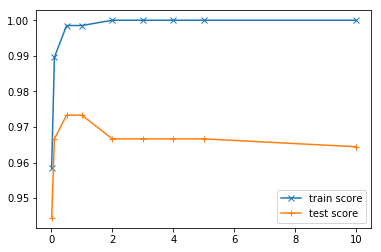

In [65]:
train_score=[]
test_score=[]
x=np.array([0.01,0.1,0.5,1,2,3,4,5,10])
#x=np.arange(0.1,2,0.1)
for c in x:
    lr8 = LogisticRegression(solver='lbfgs', multi_class='multinomial',C=c)
    lr8.fit(x_train_scaled, y_train)
    train_score=np.append(train_score,lr8.score(x_train_scaled,y_train))
    test_score=np.append(test_score,lr8.score(x_test_scaled,y_test))
    
plt.plot(x,train_score,'x-',label='train score')
plt.plot(x,test_score,'+-',label='test score')
plt.legend()
plt.show()

Perform a cross validation to find the optimal value of C. The model performed the best when $C=0.9$.

In [66]:
from sklearn.linear_model import LogisticRegressionCV
lrcv = LogisticRegressionCV(Cs=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9],cv = 10, penalty = 'l2', solver = 'lbfgs', multi_class = 'multinomial',n_jobs = -1)
lrcv.fit(x_train_scaled,y_train)
print("The optimal value of C is: %f" %lrcv.C_[0])
print("The average test accuracy is: %f"%lrcv.scores_[0][:,np.where(lrcv.Cs_==lrcv.C_[0])[0][0]].mean())

The optimal value of C is: 0.900000
The average test accuracy is: 0.968904


Plot the model's coefficients (ignoring intercept, if your model has one) as an image; does it have any intuitive interpretation?

In [10]:
# run baseline model after tuning hyper-paremeters
lr = LogisticRegression(penalty='l2',C=0.9,solver='lbfgs', multi_class='multinomial')
lr.fit(x_train_scaled, y_train)
print("Train score: %f" % lr.score(x_train_scaled, y_train))# train accuracy: 99.85%
print("Test score: %f" % lr.score(x_test_scaled, y_test))# test accuracy: 97.33%

Train score: 0.998515
Test score: 0.973333


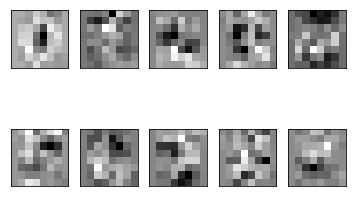

In [11]:
# TODO - Your code here
show_images(lr.coef_)

---

**Remarks (1.1)**

(i) Hyper-parameter choice/tuning; remarks on test performance, if any.
1. Given a multi-class problem, I choose multinomial rather than one-hot because multinomial will be efficient in training time and obtain better performance by taking into consideration all classes.
2. After comparing the performance of different norms of regularization and different solvers, the L2 norm with 'lbfgs' solver performs the best. The reason that I choose L2 rather than L1 is that the L2 model isn't overfitting very much and the result shows that there aren't uncorrelated features to get rid of. The reason that I choose 'lbfgs' is that the dataset isn't very large, so the schocastic gradient descent algorithm doesn't perform better. 
3. Then I perform a 10-fold cross validation to tune the value of C and find that when C=0.9, the test performance is the best.
4. Finally, I train a logistic regression model with L2 regularizer, 'lbfgs' solver and C=0.9. The train accuracy is 99.85% and test accuracy is 97.33%.

(ii) Intuitive interpretation of coefficients?

According to the coefficient images, the coefficients are  intuitive interpretation. We can get some main features of different classes based on the coefficients.

---

### 1.2.1 Two-layer perceptron

Next, train a two-layer perceptron.  Explain how you chose the number of hidden units, any other model settings/hyper-parameters (as applicable), and evaluate your model on the test set.

In [7]:
# TODO - Your code here
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.utils import to_categorical
from keras import regularizers

# Binary vector representation of targets 
y3_train = to_categorical(y_train)
y3_test = to_categorical(y_test)

n_output = y3_train.shape[1]
n_input = x_train_scaled.shape[1]

nn_2lp = Sequential() 
nn_2lp.add(Dense(units=512, input_dim= n_input, activation = 'relu'))
nn_2lp.add(Dense(units=n_output,activation='softmax'))
          #kernel_regularizer = regularizers.l1(0.005),bias_regularizer = regularizers.l1(0.005)))
nn_2lp.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h = nn_2lp.fit(x_train_scaled, y3_train, epochs = 120, batch_size = 20, validation_data = (x_test_scaled, y3_test),verbose = 0)
print("train score: %f"%nn_2lp.evaluate(x_train_scaled,y3_train)[1])
print("test score: %f"%nn_2lp.evaluate(x_test_scaled,y3_test)[1])

1347/1347 [==============================] - 0s 41us/step
train score: 1.000000
450/450 [==============================] - 0s 46us/step
test score: 0.977778


In [18]:
nn_2lp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                5130      
Total params: 38,410
Trainable params: 38,410
Non-trainable params: 0
_________________________________________________________________


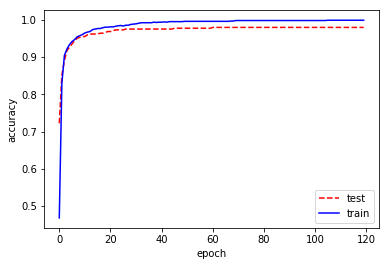

In [19]:
plt.figure()
plt.plot(h.history['val_acc'],'r--',label ='test') 
plt.plot(h.history['acc'],'b-',label ='train') 
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

In [150]:
# experiment on different numbers of hidden nodes
n_hidden=[64, 128, 256, 512, 1000]
for index,n in enumerate(n_hidden):
    nn_2lp_ = Sequential() 
    nn_2lp_.add(Dense(units=n, input_dim= n_input, activation = 'relu'))
    nn_2lp_.add(Dense(units=n_output,activation='softmax'))
          #kernel_regularizer = regularizers.l1(0.05),bias_regularizer = regularizers.l1(0.05)))
    #nn_2lp_.add(Dropout(0.25))
    nn_2lp_.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    h = nn_2lp_.fit(x_train_scaled, y3_train, epochs = 100, batch_size = 20, validation_data = (x_test_scaled, y3_test),verbose = 0)
    print("train score: %f(%s)"%(nn_2lp_.evaluate(x_train_scaled,y3_train)[1],n))
    print("test score: %f(%s)"%(nn_2lp_.evaluate(x_test_scaled,y3_test)[1],n))

1347/1347 [==============================] - 0s 68us/step
train score: 0.997773(64)
450/450 [==============================] - 0s 109us/step
test score: 0.966667(64)
1347/1347 [==============================] - 0s 74us/step
train score: 0.998515(128)
450/450 [==============================] - 0s 79us/step
test score: 0.977778(128)
1347/1347 [==============================] - 0s 74us/step
train score: 0.998515(256)
450/450 [==============================] - 0s 78us/step
test score: 0.975556(256)
1347/1347 [==============================] - 0s 95us/step
train score: 0.998515(512)
450/450 [==============================] - 0s 116us/step
test score: 0.980000(512)
1347/1347 [==============================] - 0s 107us/step
train score: 1.000000(1000)
450/450 [==============================] - 0s 117us/step
test score: 0.980000(1000)


In [153]:
# L1 regularizer with different parameters
cs=[0,0.001,0.002,0.005,0.008,0.01]
for index,c in enumerate(cs):
    nn_2lp_ = Sequential() 
    nn_2lp_.add(Dense(units=512, input_dim= n_input, activation = 'relu'))
    nn_2lp_.add(Dense(units=n_output,activation='softmax',
          kernel_regularizer = regularizers.l1(c),bias_regularizer = regularizers.l1(c)))
    #nn_2lp_.add(Dropout(0.2))
    nn_2lp_.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    h = nn_2lp_.fit(x_train_scaled, y3_train, epochs = 100, batch_size = 20, validation_data = (x_test_scaled, y3_test),verbose = 0)
    print("train score: %f(%s)"%(nn_2lp_.evaluate(x_train_scaled,y3_train)[1],c))
    print("test score: %f(%s)"%(nn_2lp_.evaluate(x_test_scaled,y3_test)[1],c))

1347/1347 [==============================] - 0s 83us/step
train score: 0.998515(0)
450/450 [==============================] - 0s 164us/step
test score: 0.975556(0)
1347/1347 [==============================] - 0s 86us/step
train score: 0.997030(0.001)
450/450 [==============================] - 0s 97us/step
test score: 0.975556(0.001)
1347/1347 [==============================] - 0s 92us/step
train score: 0.993318(0.002)
450/450 [==============================] - 0s 96us/step
test score: 0.975556(0.002)
1347/1347 [==============================] - 0s 101us/step
train score: 0.983667(0.005)
450/450 [==============================] - 0s 97us/step
test score: 0.962222(0.005)
1347/1347 [==============================] - 0s 94us/step
train score: 0.979955(0.008)
450/450 [==============================] - 0s 99us/step
test score: 0.960000(0.008)
1347/1347 [==============================] - 0s 87us/step
train score: 0.980698(0.01)
450/450 [==============================] - 0s 90us/step
test scor

In [154]:
# Experiment on different numbers of batches
bs=[20,50,80,100,120,150]
for index,b in enumerate(bs):
    nn_2lp_ = Sequential() 
    nn_2lp_.add(Dense(units=512, input_dim= n_input, activation = 'relu'))
    nn_2lp_.add(Dense(units=n_output,activation='softmax'))
#          kernel_regularizer = regularizers.l1(c),bias_regularizer = regularizers.l1(c)))
    #nn_2lp_.add(Dropout(0.2))
    nn_2lp_.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    h = nn_2lp_.fit(x_train_scaled, y3_train, epochs = 100, batch_size = b, validation_data = (x_test_scaled, y3_test),verbose = 0)
    print("train score: %f(%s)"%(nn_2lp_.evaluate(x_train_scaled,y3_train)[1],b))
    print("test score: %f(%s)"%(nn_2lp_.evaluate(x_test_scaled,y3_test)[1],b))

1347/1347 [==============================] - 0s 124us/step
train score: 0.998515(20)
450/450 [==============================] - 0s 79us/step
test score: 0.977778(20)
1347/1347 [==============================] - 0s 54us/step
train score: 0.994061(50)
450/450 [==============================] - 0s 63us/step
test score: 0.975556(50)
1347/1347 [==============================] - 0s 55us/step
train score: 0.987379(80)
450/450 [==============================] - 0s 64us/step
test score: 0.964444(80)
1347/1347 [==============================] - 0s 97us/step
train score: 0.983667(100)
450/450 [==============================] - 0s 89us/step
test score: 0.962222(100)
1347/1347 [==============================] - 0s 91us/step
train score: 0.982183(120)
450/450 [==============================] - 0s 100us/step
test score: 0.962222(120)
1347/1347 [==============================] - 0s 102us/step
train score: 0.975501(150)
450/450 [==============================] - 0s 156us/step
test score: 0.951111(150)


Plot the hidden layer model coefficients as images; do they have any intuitive interpretation?  Do any of them relate to the coefficients in the logistic relation model?

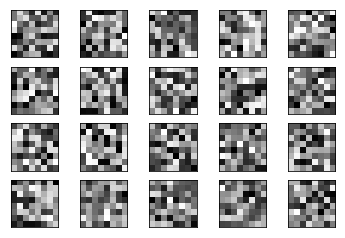

In [194]:
# TODO - Your code here
show_images(nn_2lp.layers[0].get_weights()[0].reshape(512,64)[0:20,...])

In [208]:
cor=[]
for i in range(n_output):
    a=np.dot(nn_2lp.layers[0].get_weights()[0],nn_2lp.layers[1].get_weights()[0]).reshape(10,64)[i]
    b=lr.coef_[i]
    cor.append(np.corrcoef(a,b)[0,1])
cor

[0.09250363917164521,
 0.04398597719271949,
 0.07042027919442345,
 -0.06825363010939921,
 0.1451869470694444,
 0.01779848512153279,
 0.13558069287868296,
 -0.1242079509245313,
 0.01585390049064993,
 0.002413760732239771]

---

**Remarks (1.2.1)**

(i) Number of hidden units and other hyper-parameter choice/tuning.
1. The 2LP was trained with 512 hidden units, 100 epoches, batch size=20 and activation = 'relu'. I compared different numbers of hidden units from 64 to 1000. 512 gave the best performance without obvious overfitting. The train accuracy score was 99.85% and the test accuracy score was 98%.
2. I tried to add an L1 regularizer with parameters ranged from 0 to 0.01. The results showed that the regularizer cannot improve the test performance.
3. I also studied the performance on different batch sizes and 20 gave the best performance.
4. The reasson to use relu activation function in hidden layers was that it was fast to compute and didn't suffer from vanishing gradient problems. Also I used softmax function in output layer because we were facing a multi-class problem and each class was exclusive.

(ii) Intuitive interpretation of model coefficients.

The hidden layer coefficients are not intuitive interpretation because 2LP is a non-linear model.

(iii) Relation to logistic regression model coefficients (if any).

There isn't any obvious relation betweem hidden layer coefficients and logistic regression coefficients. First, they are different in dimension. Second, logistic regression coefficients are linearly correlated to class probabilities but hidden layer coefficients are non-linearly related to class probabilities. 

---

### 1.2.2 Original vs. "learned" features

\[For this section, you can ignore the testing set\]

Plot the training samples using in a two-dimensional space, by performing PCA on the original, 64-dimensional features.  **Color each point based on it's class.**  Do any clusters emerge, and do they correspond to the classes?

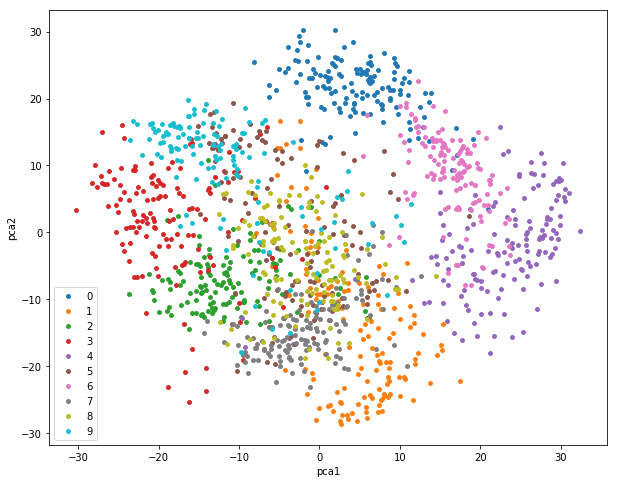

In [8]:
# TODO - Your code here
from sklearn.decomposition import PCA
import matplotlib.colors as colors
import matplotlib.cm as cmx

pca = PCA(n_components = 2)
x_train_pca = pca.fit_transform(X_train)

# visualization
uniq = list(set(y_train))
z = range(1,len(uniq))
hot = plt.get_cmap('tab10')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each digits
plt.figure(figsize=(10,8))
for i in range(len(uniq)):
    indx = y_train == uniq[i]
    plt.scatter(x_train_pca[indx,0], x_train_pca[indx,1], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.legend()

Next, repeat the same, but instead of the 64-dimensional features, use the $M$-dimensional set of first-layer values ("neuron activations") from your 2LP (where $M$ is the number of hidden units).  Do the learned, non-linear features do better, worse, or about the same wrt.\ emergent clusters?

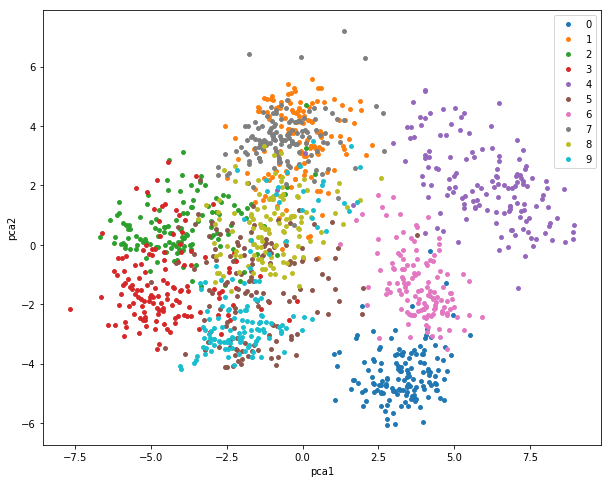

In [9]:
# TODO - Your code here
from keras.models import Model
layer_model = Model(inputs=nn_2lp.input, outputs=nn_2lp.layers[0].output)
hidden_output = layer_model.predict(x_train_scaled)

pca = PCA(n_components = 2)
x_hidden_pca = pca.fit_transform(hidden_output)

# Plot each digits
plt.figure(figsize=(10,8))
for i in range(len(uniq)):
    indx = y_train == uniq[i]
    plt.scatter(x_hidden_pca[indx,0], x_hidden_pca[indx,1], s=15, color=scalarMap.to_rgba(i), label=uniq[i])
plt.xlabel('pca1')
plt.ylabel('pca2')
plt.legend()

Apply $K$-means with $K=10$ (i.e., the number of distinct classes in the original data) on both the 64-dimensional and $M$-dimensional feature spaces.  Once the clustering is complete assign a digit label to each cluster; rather than do so manually, simply assign the "majority label" to each cluster (i.e., the label that appears more frequently among the points belonging to the cluster).  Print out the confusion matrices for both sets of 10 clusters (one matrix for each feature space).  What is the overall "accuracy" of each clustering wrt.\ recovering the original labels?  Is one better than the other, and why (same question as above, but with quantifiable results)?

In [10]:
# TODO - Your code here
from sklearn.cluster import KMeans
from scipy import stats
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score

kmeans = KMeans(n_clusters=10, random_state=20)
pred_64=kmeans.fit_predict(X_train)
pred_M=kmeans.fit_predict(hidden_output)
y_pred_64=np.zeros(y_train.shape[0],dtype=np.int64)
y_pred_M=np.zeros(y_train.shape[0],dtype=np.int64)
print('cluster#  class#(64-dim)  class#(M-dim)')
for i in list(set(pred_64)):
    y_pred_64[np.where(pred_64==i)]=stats.mode(y_train[np.where(pred_64==i)])[0][0]
    y_pred_M[np.where(pred_M==i)]=stats.mode(y_train[np.where(pred_M==i)])[0][0]
    print('  ',i,'           ', stats.mode(y_train[np.where(pred_64==i)])[0][0],'          '
          ,stats.mode(y_train[np.where(pred_M==i)])[0][0])

print('\n64-dimensional feature spaces:')
print('Confusion matrix:\n',confusion_matrix(y_train, y_pred_64))
print('Accuracy: %f\n' %accuracy_score(y_train,y_pred_64))
print('M-dimensional feature spaces:')
print('Confusion matrix: \n',confusion_matrix(y_train, y_pred_M))
print('Accuracy: %f\n'% accuracy_score(y_train,y_pred_M))


cluster#  class#(64-dim)  class#(M-dim)
   0             2            8
   1             8            3
   2             0            6
   3             4            7
   4             3            0
   5             7            2
   6             6            4
   7             1            9
   8             1            5
   9             5            1

64-dimensional feature spaces:
Confusion matrix:
 [[140   0   0   0   1   0   0   0   0   0]
 [  0 122  15   1   0   0   1   0   0   0]
 [  0   3 110   8   0   0   0   1  11   0]
 [  0   1   1 119   0   2   0   7   8   0]
 [  0   3   0   0 132   0   0   7   1   0]
 [  0   0   0  30   3  99   2   0   0   0]
 [  1   2   0   0   0   0 125   0   1   0]
 [  0   7   0   0   0   0   0 123   1   0]
 [  0  14   3   7   0   1   1   1  99   0]
 [  0  17   0 105   0   1   0   7   3   0]]
Accuracy: 0.793615

M-dimensional feature spaces:
Confusion matrix: 
 [[141   0   0   0   0   0   0   0   0   0]
 [  0 105  16   0   0   0   1   0   0  17]
 [

---

**Remarks (1.2.2)**

(i) Original feature space (pixel values), and K-means clusters on it.

Based on the visualization of original feature space, there were some clusters emerging. Clusters of digits 0, 2, 3, 4, 6 and 7 were more concentrated but clusters of digits 1, 5, 8, and 9 were relativly diverging. 

(ii) Hidden-layer features space, and K-means clusters on it.

Based on the visualization of hidden-layer feature space, there were also some clusters and most of clusters looked clearer than the original feature space. However, clusters of digits 1, 8 and 9 were relativly diverging too. 

(iii) Brief discussion of performance (confusion matrix, "accuracy" of clustering on each feature space).

1. Based on the confusion matrix, K-means clusters successfully recognized most of digits but misclassified 9 as 1 in the original feature space and misclassified 8 as 1 in hidden-layer feature space. 
2. The error rates of digits 8 and 9 were larger than other digits. This made sense because from the PCA plots above, the clusters of the two digits were diverging in both spaces.
3. The overall accuracy in the original space was 79.36% and the accuracy in the hidden-layer space was 86.56%. The performance improvemed because the hidden layer successfully extracted more useful information from the original features.

---

### 1.3 $k$-NN graph and clustering

\[For this section you can ignore the testing set\]

Write a function `knn_graph(X, k, y=None)` which accepts a $N\times D$ matrix representing a collection of $N$ $D$-dimensional points, and returns a NetworkX weighted undirected graph representing their _symmetric $k$ nearest neighbor ($k$-NN) graph_ using Euclidean distance.  Use the row number `i`, $0\le i < N$, as the node IDs and store the edge weights in the `weight` edge attribute.  Also, for each node, add a `features` node attribute that stores the $D$-dimensional vector, for convenient access.  Furthermore, if the `y` argument is provided, use it to assign a `label` node attribute value, again for convenient access.

The _symmetric $k$-NN graph_ has an edge between nodes $i$ and $j$ if either $j$ is in among the $k$ nearest neighbors of $i$ or vice-versa (i.e., $i$ is among the $k$-NNs of $j$).  

Formally, given nodes/points $0\le i,j< N$, the set of $k$-NNs of $i$ is defined as
$$ \mathcal{N}^{(k)}(i) := \{ j \mid j\ne i \text{ and } \|\mathbf{x}_j - \mathbf{x}_i\| \le d^{(k)}(i) \} $$
where $d^{(k)}(i)$ denotes the $k$-th smallest value in the sequence of distances $( \|\mathbf{x}_i-\mathbf{x}_j\|)_{0\le j< N \text{ and } j\ne i}$.  Note that $|\mathcal{N}^{(k)}(i)| \ge k$; if there are ties, the $k$-NN set may have more than $k$ elements.  Given this definition, the $k$-NN graph's edges are defined by
$$ (i,j)\in E \quad\text{ if and only if }\quad i \in \mathcal{N}^{(k)}(j) \text{ or } j \in \mathcal{N}^{(k)}(i) $$
with node weights equal to their distance,
$$ w(i,j) := \|\mathbf{x}_i - \mathbf{x}_j\|. $$
Clearly, if $k=N$, the $k$-NN graph becomes the standard Euclidean matrix.

In [5]:
# TODO - Your code here
import networkx as nx
from sklearn.neighbors import NearestNeighbors

def knn_graph(X, k, y=None):
    N=X.shape[0]
    D=X.shape[1]
    knn = NearestNeighbors(metric='euclidean', algorithm='brute', n_neighbors=k+1, n_jobs=-1)
    knn.fit(X)
    distance,indice=knn.kneighbors(X,n_neighbors=k+1)
    G = nx.Graph()
    G.add_nodes_from(list(np.arange(N)))
    nx.set_node_attributes(G, dict(zip(list(np.arange(N)),list(X))),'feature')
    if y is not None:
        nx.set_node_attributes(G,dict(zip(list(np.arange(N)),list(y))),'label')
    for i in range(N):
        for j in range (k):
            G.add_edge(i, indice[i,j+1], weight=distance[i,j+1])
    return G

**Why do you think** that using the $k$-NN graph, rather than the full Euclidean distance matrix (i.e., the $N$-NN graph) might intuitively be better or worse?

For each value of $k=1$, $3$, and $10$, construct the $k$-NN graph of the original $D=64$ dimensional features (pixel values), and draw it using a **spectral layout**. **Color each vertex according to it's label**.
How well do the graphs recover the original labels?  Do any values of $k$ perform differently?  Please draw the graphs in **one plot with three sub-plots on one row**.

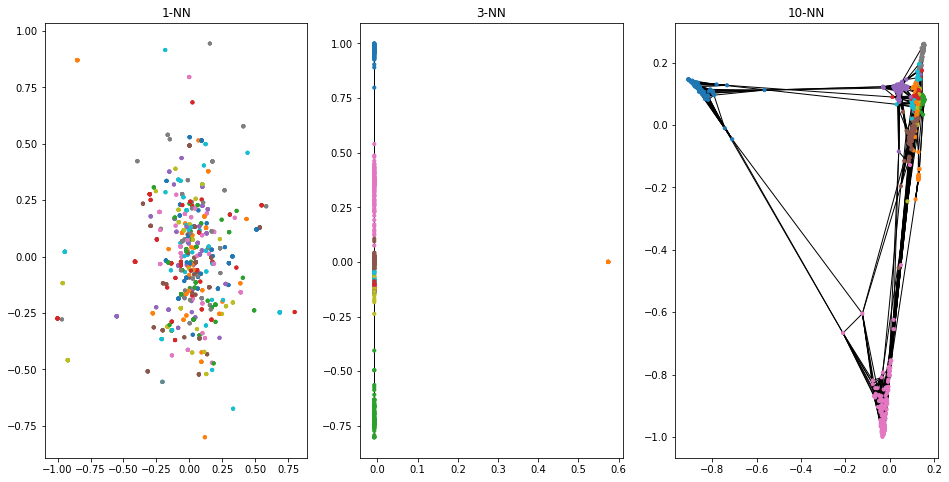

In [131]:
# TODO - Your code here
G1=knn_graph(X_train,k=1,y=y_train)
G3=knn_graph(X_train,k=3,y=y_train)
G10=knn_graph(X_train,k=10,y=y_train)

#colors = list(nx.get_node_attributes(G1,'label'))#[i/len(G.nodes) for i in range(len(G.nodes))]
#f, axes = plt.subplots(1,3, figsize=(17,4), sharex=False)
plt.figure(figsize=(16,8))
plt.subplot(131)
nx.draw_networkx(G1, pos=nx.spectral_layout(G1), node_size=10,
                 node_color=list(nx.get_node_attributes(G1,'label').values()),
                 cmap = plt.cm.get_cmap('tab10'),with_labels=False)
plt.title('1-NN')

plt.subplot(132)
nx.draw_networkx(G3, pos=nx.spectral_layout(G3), node_size=10, 
                 node_color=list(nx.get_node_attributes(G3,'label').values()),
                 cmap = plt.cm.get_cmap('tab10'),with_labels=False)
plt.title('3-NN')

plt.subplot(133)
nx.draw_networkx(G10, pos=nx.spectral_layout(G10), node_size=10, 
                 node_color=list(nx.get_node_attributes(G10,'label').values()),
                 cmap = plt.cm.get_cmap('tab10'),with_labels=False)
plt.title('10-NN')
plt.show()

Finally, partition the $k$-NN graph for $k=3$ to $K=10$ sets of vertices.  Describe the partitioning method you chose and _briefly_ explain why.  Again, use majority-labeling for each partition and, based on this, print out the confusion matrix and report overall accuracy (i.e., sum of diagonals over sum of all elements of confusion matrix).  Briefly discuss how this performs versus previous $K$-means clustering approaches.

In [46]:
from networkx.algorithms.community.centrality import girvan_newman
import itertools

# 3nn cut
G3_gn = girvan_newman(G3)
for communities in itertools.islice(G3_gn, 7,8):
    G3_gn_10=tuple(sorted(c) for c in communities)

In [55]:
# 10nn cut
import time
start=time.time()
G10_gn = girvan_newman(G10)
i=0
for communities in itertools.islice(G10_gn, 8,9):
    print(i)
    G10_gn_10=tuple(sorted(c) for c in communities)
    i=i+1
print('time cost:',time.time()-start)

0
time cost: 18597.051136016846


In [57]:
y_pred_3nn=np.zeros(y_train.shape[0],dtype=np.int64)
y_pred_10nn=np.zeros(y_train.shape[0],dtype=np.int64)

print('cut#  class#(64-dim)  class#(M-dim)')    
for i in range(len(G3_gn_10)):
    y_pred_3nn[G3_gn_10[i]]=stats.mode(y_train[G3_gn_10[i]])[0][0]
    y_pred_10nn[G10_gn_10[i]]=stats.mode(y_train[G10_gn_10[i]])[0][0]
    print(' ',i,'           ', stats.mode(y_train[G3_gn_10[i]])[0][0],'          '
          ,stats.mode(y_train[G10_gn_10[i]])[0][0])

print('\n3NN Graph:')
print('Confusion matrix:\n',confusion_matrix(y_train, y_pred_3nn))
print('Accuracy: %f\n' %accuracy_score(y_train,y_pred_3nn))
print('10NN Graph:')
print('Confusion matrix: \n',confusion_matrix(y_train, y_pred_10nn))
print('Accuracy: %f\n'% accuracy_score(y_train,y_pred_10nn))

cut#  class#(64-dim)  class#(M-dim)
  0             2            2
  1             8            8
  2             3            3
  3             7            7
  4             4            4
  5             6            6
  6             5            5
  7             0            0
  8             1            1
  9             1            1

3NN Graph:
Confusion matrix:
 [[141   0   0   0   0   0   0   0   0   0]
 [  0  40   0   0   0   0   0   0  99   0]
 [  0   0 133   0   0   0   0   0   0   0]
 [  0   0   0 136   0   0   0   2   0   0]
 [  0   0   0   0 140   0   0   3   0   0]
 [  0   0   0   0   0 133   1   0   0   0]
 [  0   0   0   0   0   0 129   0   0   0]
 [  0   0   0   0   0   0   0 131   0   0]
 [  0   0   0   0   0   0   0   0 126   0]
 [  0  16   0 100   0   6   0   9   2   0]]
Accuracy: 0.823311

10NN Graph:
Confusion matrix: 
 [[141   0   0   0   0   0   0   0   0   0]
 [  0  62   0   0   0   0   0   0  77   0]
 [  0   0 133   0   0   0   0   0   0   0]
 [  0   0  

---

**Remarks (1.3)**

(i) Why/when might the $k$-NN graph be better/worse than the full Euclidean distance matrix?

The $k$-NN graph can connect points on differnt scale so points in low density can be connected to points in high density. Also, it can ignore irrelavant nodes. The full Euclidean distance matrix is usually only chosen if the similarity function itself already encodes mainly local neighborhoods. 

(ii) Discussion on various $k$ values and how well they might recover classes.

According to the K-NN graph, 1-NN can hardly sperate classes. However, both 3-NN and 10-NN can seperate points from different classes. So the recover performance didn't change a lot for $k$ from 3 to 10.

(iii) Describe and _briefly_ justify your graph partitioning method.

I used Girvan-Newman method to cut the graph. According to the graph above, points from the same class tend to get together. So the edges between two different clusters will have larger betweenness. So we can cut the graph by deleting the edges with the maximal betweenness. That's why I used Girvan-Newman method.

(iv) Briefly discuss partitioning of the $k$-NN graph vs. $K$-means on the original feature space.

The partitioning of 3-NN graph and 10-NN graph is similar. Both accuracy is near 82%, which is slightly higher than the accuracy of K-means of original spaces. However, both K-NN graph and K-means cannot identify the class of digit 9.

---

### 1.4 Open-ended analysis

Devise your own method, either supervised or unsupervised (choose one of the two), to discover digits from images.  You may use methods available in Scikit-learn, Keras/Tensorflow, and NetworkX. Describe, _concisely_ but _accurately_, _what_ you did and, more importantly, _why_ you did it.

You might want to leave this section for the end.  Your approach does not have to be Turing-award winning research!  I am mostly interested in seeing _how you approach a problem_ and _how you think_, rather than in the result itself.  You can think of this as a job interview question, where the goal is very similar.  Be _clear_ and _precise_, while keeping your answers _short and to the point_.  

Include any code and plots you deem necessary to support your decisions and your analysis, as well as briefly illustrate it's results.  Feel free to create as many code and markdown cells as necessary. 

**However**, please summarize your overall approach and analysis in the "Remarks (1.4)" cell; your summary should be self-contained (you can of course reference other cells for _further_ details, but it should be possible to understand your summary on it's own).  Please structure your overall work to avoid repetition (e.g., do not just copy-paste all the text before the "Remarks" cell).

In [155]:
# TODO
img_rows, img_cols = 8, 8
input_shape = (img_rows, img_cols, 1)
x3_train=X_train.reshape(X_train.shape[0], img_rows, img_cols)
x3_test=X_test.reshape(X_test.shape[0], img_rows, img_cols)
X3_train = x3_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X3_test = x3_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X3_train = X3_train.astype('float32')
X3_test = X3_test.astype('float32')
X3_train/= 255
X3_test/= 255
y3_train = to_categorical(y_train)
y3_test = to_categorical(y_test)

In [172]:
from keras.layers.normalization import BatchNormalization

cnn2 = Sequential()
cnn2.add(Conv2D(32, kernel_size=(3, 3),strides = (1, 1), padding = 'same',
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_shape))
cnn2.add(Conv2D(64, (3, 3), activation='relu'))
cnn2.add(Conv2D(128, (3, 3), activation='relu'))
cnn2.add(MaxPooling2D((2, 2)))

cnn2.add(Flatten())

cnn2.add(Dense(128, activation='relu'))
cnn2.add(Dropout(0.25))
cnn2.add(Dense(n_classes, activation='softmax'))

cnn2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [174]:
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 8, 8, 32)          320       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 6, 6, 64)          18496     
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 2, 2, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
__________

In [173]:
h2 = cnn2.fit(X3_train, y3_train, epochs = 100, batch_size = 20, 
                      validation_data = (X3_test, y3_test), verbose = 0)
print("train score : %f" % cnn2.evaluate(X3_train, y3_train)[1])
print("test score : %f" % cnn2.evaluate(X3_test, y3_test)[1])

1347/1347 [==============================] - 0s 229us/step
train score : 1.000000
450/450 [==============================] - 0s 222us/step
test score : 0.988889


---

**Remarks (1.4)**

Brief but complete and self-contained summary of _what_ you did and _why_.

I designed a CNN model to the data because CNN usually performs well on image data. The best test accuracy I've got for 2LP is 98% and I hope to improve the performance with CNN. Specifically, I built three convolution layers with 32, 64 and 128 nodes and one full-connected layer with 128 nodes. The third convolution layer was followed by a $2\times2$ maxpooling layer and the full-connected layer was followed by a dropout layer with degree of 0.25. I used 'relu' as activation function for every layer expect for the output layer with softmax function. The network was optimised by Adam with 100 epochs. The batch size was 20. The train score was also 100% and the test score was 98.88%, 0.9% better than 2LP.

---

## Part 2: Karate club

[Zachary's karate club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) is a tiny but famous (almost cult?) dataset in network science. You can read more about the story behind it in the linked Wikipedia article (note that the NetworkX version's vertex IDs start from 0, not 1, hence "Mr. Hi" is 0 and "John A." is 33).

In [58]:
import networkx as nx

Gzk = nx.karate_club_graph()

Let's take a look at the graph (you don't have to use the same style in your plots, by the way):

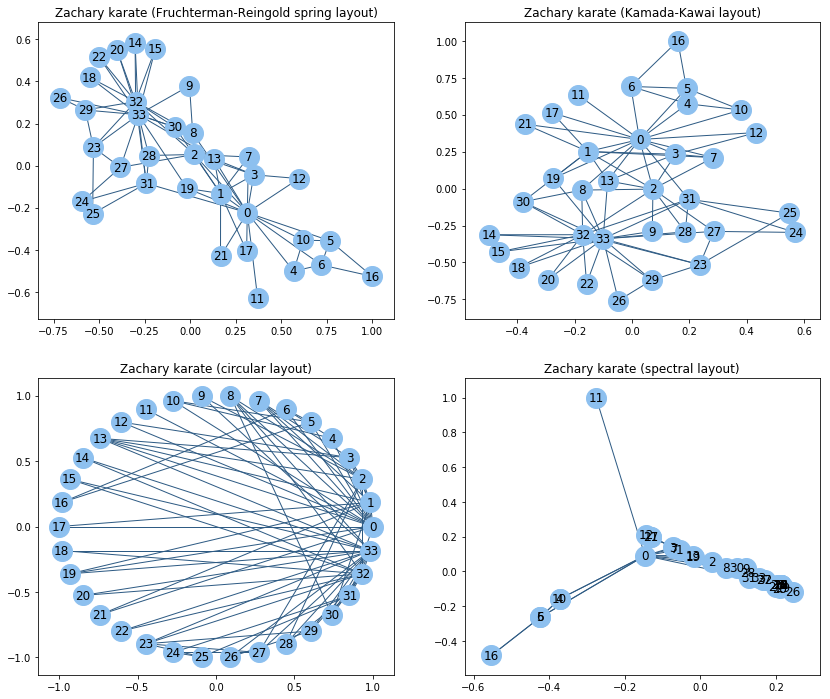

In [59]:
plt.figure(figsize=(14,12))
plt.subplot(2,2,1)
nx.draw_networkx(Gzk, pos=nx.drawing.spring_layout(Gzk, seed=10), 
                 node_size=400, node_color='#8dc0ef', edge_color='#2e5b84')
plt.title('Zachary karate (Fruchterman-Reingold spring layout)')
plt.subplot(2,2,2)
nx.draw_networkx(Gzk, pos=nx.drawing.kamada_kawai_layout(Gzk), 
                 node_size=400, node_color='#8dc0ef', edge_color='#2e5b84')
plt.title('Zachary karate (Kamada-Kawai layout)')
plt.subplot(2,2,3)
nx.draw_networkx(Gzk, pos=nx.drawing.circular_layout(Gzk), 
                 node_size=400, node_color='#8dc0ef', edge_color='#2e5b84')
plt.title('Zachary karate (circular layout)')
plt.subplot(2,2,4)
nx.draw_networkx(Gzk, pos=nx.drawing.spectral_layout(Gzk), 
                 node_size=400, node_color='#8dc0ef', edge_color='#2e5b84')
plt.title('Zachary karate (spectral layout)')
None  # Suppress cell output

Note that the spectral layout does rather poorly...

### 2.1 Graph partitioning

Find binary partitionings of the graph using each of the following methods: (i) Zachary's original method (i.e., $s-t$ min-cut, with $s=0$ and $t=33$); (ii) Girvan-Newman; (iii) spectral partitioning (based on the Fiedler vector alone).  Draw the resulting graphs with vertex colors corresponding to the partition (you can leave cut-set edges in the drawing); please place all plots as subplots in the same figure.

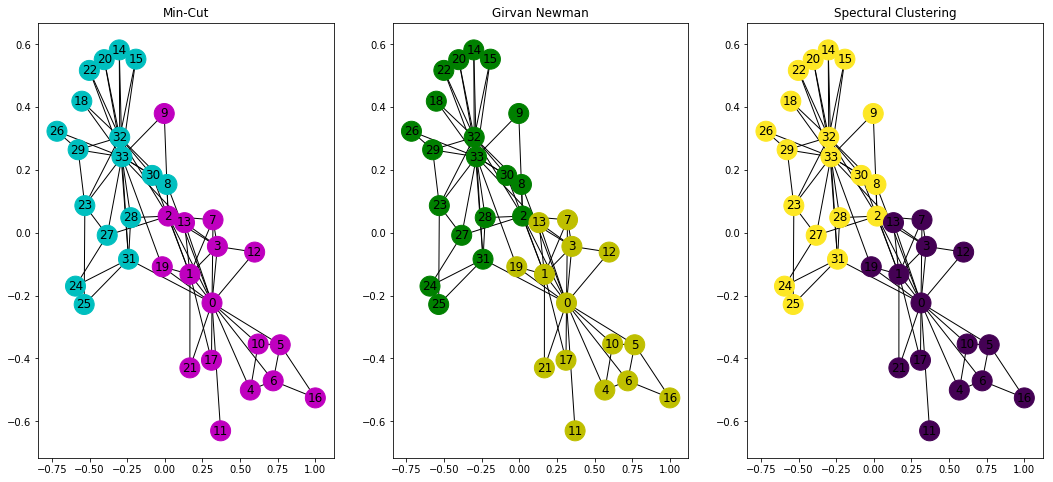

In [105]:
# TODO - Your code

from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.connectivity.cuts import minimum_st_edge_cut

# (i) Zachary's original method (i.e.,  𝑠−𝑡  min-cut, with  𝑠=0  and  𝑡=33 ); 
Gzk_min = minimum_st_edge_cut(Gzk,0,33)
G_=Gzk.copy()
Gzk_min=list(Gzk_min)
G_.remove_edges_from(Gzk_min)
Gzk_min=tuple(nx.connected_components(G_))

#(ii) Girvan-Newman

Gzk_gn = girvan_newman(Gzk)
Gzk_gn = tuple(sorted(c) for c in next(Gzk_gn))

#(iii) spectral partitioning (based on the Fiedler vector alone)
Gzk_fv = nx.fiedler_vector(Gzk)
Vs_eig = set(vi for i, vi in enumerate(Gzk.nodes()) if Gzk_fv[i] >= 0)
Vt_eig = set(Gzk.nodes) - Vs_eig
G_fv = [Vs_eig,Vt_eig]


# Draw graph
plt.figure(figsize=(18,8))
plt.subplot(131)
nx.draw_networkx(Gzk, pos=nx.drawing.spring_layout(Gzk, seed=10), node_size=400, with_labels=True, 
                 node_color=['m' if v in Gzk_min[0] else 'c' for v in Gzk.nodes()])
plt.title('Min-Cut')

plt.subplot(132)
nx.draw_networkx(Gzk, pos=nx.drawing.spring_layout(Gzk, seed=10), node_size=400, with_labels=True, 
                 node_color=['y' if v in Gzk_gn[0] else 'g' for v in Gzk.nodes()])
plt.title('Girvan Newman')

plt.subplot(133)
nx.draw_networkx(Gzk, pos=nx.drawing.spring_layout(Gzk, seed=10), node_size=400, with_labels=True,
                 node_color=1.0*(Gzk_fv >= 0.0))
plt.title('Spectural Clustering')
plt.show()

Next, from each partitioning select the set which contains Mr. Hi (node 0); let's call those the "loyals" of the partitioning.  Then, for all three partitionings, compute the Jaccard similarity score between the partitioning's "loyals".  Which partitionings are more similar?  Any intuition why that would be the case?

In [130]:
# TODO - Your code
#from sklearn.metrics import jaccard_similarity_score

def jaccard_similarity(A,B):
    n_inter=len(A.intersection(B))
    n_union=len(A.union(B))
    return n_inter/n_union

loyal_min=[Gzk_min[i] for i in range(2) if 0 in Gzk_min[i]][0]
loyal_gn=[set(Gzk_gn[i]) for i in range(2) if 0 in Gzk_gn[i]][0]
loyal_fv=[G_fv[i] for i in range(2) if 0 in G_fv[i]][0]

print('Jaccard similarity (Min-Cut vs Girvan Newman): ',jaccard_similarity(loyal_min,loyal_gn))
print('Jaccard similarity (Min-Cut vs Fiedler Vector): ',jaccard_similarity(loyal_min,loyal_fv))
print('Jaccard similarity (Girvan Newman vs Fiedler Vector): ',jaccard_similarity(loyal_gn,loyal_fv))

Jaccard similarity (Min-Cut vs Girvan Newman):  0.8823529411764706
Jaccard similarity (Min-Cut vs Fiedler Vector):  0.8823529411764706
Jaccard similarity (Girvan Newman vs Fiedler Vector):  1.0


---

**Remarks (2.1)**

_Brief_ discussion of similarities/differences between partitionings based on different methods.

The Girvan-Newman method and spectral method obtained the same partioning on the orginal graph. However, the min-cut was slightly differnt from the other two methods. Specifically, Node 2 and Node 9 belong to different partitionings in min-cut method and the other two methods.


---

### 2.2 Node rankings

Print out the vertex IDs (all 33) ranked according to the following centrality scores: (i) degree; (ii) closeness; (iii) shortest-path betweenness; (iv) PageRank. Also report all pairwise Kendall rank correlation coefficients $\tau$. How do Mr. Hi and John A. rank?  How does PageRank compare to degree ranking?  How do other rankings compare?

In [81]:
# TODO - Your code
Cf_deg = nx.degree_centrality(Gzk)
Cf_cls = nx.closeness_centrality(Gzk)
Cf_btw = nx.betweenness_centrality(Gzk)
Cf_pgr = nx.pagerank(Gzk)

score_deg = np.array(list(Cf_deg[v] for v in Gzk.nodes))
score_cls = np.array(list(Cf_cls[v] for v in Gzk.nodes))
score_btw = np.array(list(Cf_btw[v] for v in Gzk.nodes))
score_pgr = np.array(list(Cf_pgr[v] for v in Gzk.nodes))

df = pd.DataFrame({'degree':score_deg,
                   'closeness':score_cls,
                   'betweenness':score_btw,
                   'pagerank':score_pgr})
df_node=pd.DataFrame({'Degree':df['degree'].sort_values(ascending=False).index,
                     'Closeness':df['closeness'].sort_values(ascending=False).index,
                     'Betweenness':df['betweenness'].sort_values(ascending=False).index,
                     'PageRank':df['pagerank'].sort_values(ascending=False).index})
# print out
print('Node ranking with different centrality scores:')
print (df_node)


print('\nKendall tau correlation matrix:')
print(df.corr('kendall'))

Node ranking with different centrality scores:
    Degree  Closeness  Betweenness  PageRank
0       33          0            0        33
1        0          2           33         0
2       32         33           32        32
3        2         31            2         2
4        1         13           31         1
5       31         32            8        31
6        3          8            1         3
7       23         19           13        23
8       13          1           19         8
9        8          3            5        13
10      27         30            6         5
11       5         27           27         6
12       6         28           23        29
13      29          7           30        27
14      30          9            3        30
15       7         23           25         7
16      25         29           29        10
17      24          5           24         4
18      28          6           28        24
19      10          4            9        25
20      

---

**Remarks (2.2)**

_Brief_ discussion of similarities/differences between various node rankings.

1. The correlation between degree and PageRank is very high because the more edges that connect to a node, the more possible to reach the node. 
2. The correlations between degree and the other two measures are relatively lower because degree only considers local information of a vertice but the other two measures take into consider the overall informaion in the graph. However, the three measures are still potively correlated with each other. This is reasonable because degree measures the closer of a node to other nodes, the more shortest paths will go through that node.
3. Mr. Hi ranked the first in Closeness and Betweenness and ranked the second in Degree and PageRank. John A. ranked the first in Degree and PageRank, ranked the second in Betweenness and ranked the third in Closeness.

---

## Part 3: Written questions

For this part, you do not need to write any code.  Type in your answers completely within the Markdown cell corresponding to each question.  Please use LaTeX for any equations you might need to write.

### 3.1 Spectrum and connectedness

Prove that the Laplacian of an undirected, unweighted graph has zero eigenvalue with multiplicity equal to the number of connected components.

\[ Hint: _One_ way to approach this (but not the _only_ one, clearly) is to first quickly prove that the above reduces to showing that a connected graph has zero eigenvalue with multiplicity one. \]

---

**Answer (3.1)**

First, suppose that $G$ is a connected graph with Laplacian of $L$. The adjacent matrix is $W$ with elements $w_{ij}$. Assume that $f$ is an eigenvector with eigenvalue 0. According to the definition of eigenvector,
$$Lf=0f=0$$
Since $f^TLf=\sum_{i}\sum_{j}w_{ij}(f_i-f_j)^2$, so we have
$$f^TLf=\sum_{i}\sum_{j}w_{ij}(f_i-f_j)^2=0$$
Since G is a connected graph, $w_{ij}\not=0$ for any $i$ and $j$. So $f_i=f_j$. That is to say, there is only one eigenvector with eigenvalue 0. So the multiplicity of zero eigenvalue is one.

Then, consider $G$ as an undirected, unweighted graph with $k$ connected components. We assume that the vertices are ordered according to the connected components they belong to. In this case, the adjacency matrix $W$ has a block diagonal form, and the same is true for the matrix $L$:
$$\begin{equation}
L
=\begin{bmatrix}
L_1  &    &  &\\
  &  L_2  &  & \\
  &  & \ddots  &   \\
  &   & & L_k\\
\end{bmatrix}
\end{equation}
$$
where each of the blocks $L_i$ is the Laplacian corresponding to the subgraph of the $i$th connected component. So according to the proof above, every $L_i$ has eigenvalue 0 with multiplicity 1. Furthermore, eigenvectors of $L$ are the eigenvectors of $L_i$, filled with 0 at the positions of the other blocks. So $L$ has eigenvalue 0 with multiplicity $k$, which is equal to the number of connected components.

---

### 3.2 NN error functions

For binary classification problems using a network with a logistic output activation function $\sigma(a)$, where the target variable takes values $t\in \{0,1\}$, we derived the appropriate error function as the _cross-entropy_ given by
$$ E(\mathbf{w}) := -\sum_n\left[t_n\ln y_n + (1-t_n)\ln(1-y_n)\right].  $$

Instead of a $0/1$ target variable, consider a $-1/+1$ target variable.  Show that an appropriate activation function would be the hyperbolic tangent ($\tanh$) and derive the corresponding error function.

\[ Hint: Consider the linear transformation mapping $\{0,1\}$ into $\{-1,+1\}$. \]

---

**Answer (3.2)**

Given the target variable $t\in \{0,1\}$, we can transform to $s\in\{-1,1\}$ by letting
$$s=2t-1$$
Since $t=\sigma(x)=\frac{1}{1+e^{-x}}$ , we have 
$$s=2\sigma(x)-1=\frac{2}{1+e^{-x}}-1=\frac{1-e^{-x}}{1+e^{-x}}=\frac{e^{\frac{x}{2}}-e^{-\frac{x}{2}}}{e^{\frac{x}{2}}+e^{-\frac{x}{2}}}=tanh(\frac{x}{2})$$
So tanh is an appropriate activation function for the -1/+1 target variable.
Correspondingly, the error function can be written as:
$$ E(\mathbf{w}) := -\sum_n\left[\frac{1}{2}(s_n+1)\ln \frac{1}{2}(y_n+1) + (\frac{1}{2}-\frac{1}{2}s_n)\ln\frac{1}{2}(1-y_n)\right]\\
=-\sum_n\left[\frac{1}{2}(s_n+1)\ln(y_n+1)+\frac{1}{2}(1-s_n)\ln(1-y_n)-\ln2\right]$$
where $y_n$ is the true label and $s_n$ is the predicted value.

---